True


(<Figure size 1100x600 with 1 Axes>, <Axes: >)

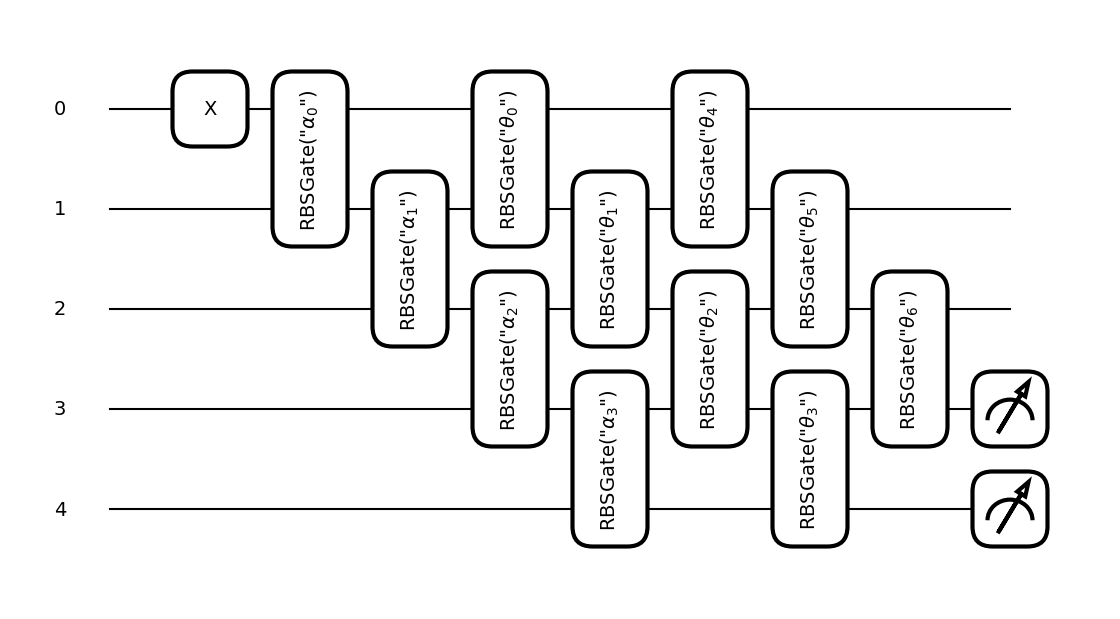

In [1]:
import numpy as np
import torch 
from sklearn.model_selection import train_test_split

import pennylane as qml
from pennylane.operation import Operation, AnyWires

#dev0 = qml.device("default.qubit",wires=3)
print(torch.cuda.is_available())
class RBSGate(Operation):
    num_wires = 2  

    def __init__(self, theta, wires, id=None):
        all_wires = qml.wires.Wires(wires)
        super().__init__(theta, wires=all_wires, id=id)

    @staticmethod
    def compute_decomposition(theta, wires):
        decomp = [
                qml.Hadamard(wires=wires[0]),
                qml.Hadamard(wires=wires[1]),
                qml.CZ(wires=wires),
                qml.RY(theta/2.,wires=wires[0]),
                qml.RY(-theta/2.,wires=wires[1]),
                qml.CZ(wires=wires),
                qml.Hadamard(wires=wires[0]),
                qml.Hadamard(wires=wires[1])
            ]
        return decomp
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def probs_single(inputs, weights):
    shape=[5,2]
    
    qml.PauliX(wires=0)
    # make the input vector norm1
    
    # load input
    prd_fact=1.0
    for qi in range(0,shape[0]-1):
        theta_i=torch.arccos((inputs[...,qi])/prd_fact)#removed np.sqrt
        prd_fact=prd_fact*torch.sin(theta_i)
#        print(f"qubit: {qi}, input: {inputs[...,qi]}, fact_new: {prd_fact}, theta_i: {theta_i}")
#        input()
        RBSGate(theta_i,wires=[qi,qi+1],id=f"$\\alpha_{qi}$")
    
    # parametric circuit
    ctr=0
    for j in range(shape[1]):
        for i in range(0,shape[0]-j-1):
            RBSGate(weights[0][ctr],[i,i+1],id=f"$\\theta_{ctr}$")
            ctr+=1    
    return qml.probs(wires=range(shape[0]-shape[1],shape[0]))


qml.draw_mpl(probs_single)(torch.tensor([list(range(5)),]),torch.tensor([list(range(7)),]))
        

(100,)
100


wandb: Currently logged in as: giacomoantonioli (quantum_kets). Use `wandb login --relogin` to force relogin


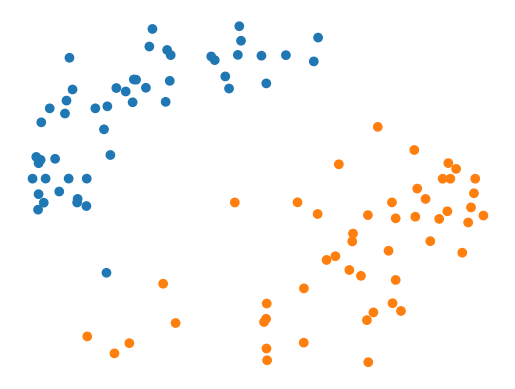

67
tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]])


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd
iris_data = load_iris()
iris_df = pd.DataFrame(data=iris_data['data'], columns=iris_data['feature_names'])

iris_df['Iris type'] = iris_data['target']
iris_df = iris_df[iris_df["Iris type"] != 2]
iris = iris_df.to_numpy()

X = iris[:, :4]  # we only take the first two features.
y = np.ndarray.tolist(iris[:, 4].astype(int))

print(np.shape(y))

lendataset = len(y)
print(lendataset)
#print(y)


from sklearn.datasets import make_moons
import wandb

wandb.login()
def stereo_pj(X):
    n,m=np.shape(X)
    newX=np.zeros((n,m+1))
    for rowindex,x in enumerate(X):
        s=np.sum(pow(x,2))
        for index in range(m):
            newX[rowindex,index]=2*x[index]/(s+1)
        newX[rowindex,m]=(s-1)/(s+1)
    return newX

X_mean, X_std=np.mean(X,axis=0), np.std(X,axis=0,ddof=1)

X=(X-X_mean)/X_std

X=stereo_pj(X)
y_ = torch.unsqueeze(torch.tensor(y,requires_grad=False), 1)  # used for one-hot encoded labels
y_hot_temp = torch.scatter(torch.zeros((100, 2),requires_grad=False), 1, y_, 1)
y_hot=torch.zeros((100, 4),requires_grad=False)
y_hot[:,1:3]=y_hot_temp

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()
X_train, X_val, y_train, y_val = train_test_split(
    X, y_hot, test_size=0.33, random_state=42)
lendataset = len(y_train)
print(lendataset)
val_len=len(y_val)
print(y_val)

In [3]:
n_layers = 1
n_pars = 7
weight_shapes = {"weights": (n_layers, n_pars)}
qlayer = qml.qnn.TorchLayer(probs_single, weight_shapes)
rand_weights = torch.nn.Parameter(torch.rand(7,)*2)
#qlayer.weights=rand_weights
clayer_1 = torch.nn.Linear(3, 3)


softmax_pre = torch.nn.Softmax(dim=1)
softmax = torch.nn.Softmax(dim=1)

optimizers=["SGD","ADAM","ADAMW","RMSPROP"]
epochs_list = [5,20,50]
lr_list=[0.9,0.2,0.01,0.001,0.5,0.1,0.005,0.0001]
layers = [qlayer]


for optindex in optimizers:
    for epochs in epochs_list:
        for lr in lr_list:
            qlayer = qml.qnn.TorchLayer(probs_single, weight_shapes)
            rand_weights = torch.nn.Parameter(torch.rand(7,)*2)
            #qlayer.weights=rand_weights
            layers = [qlayer]
 
            model = torch.nn.Sequential(*layers)
            print(model)
            
            print([pm for pm in model.parameters()])
            match optindex:
                case "SGD":
                     opt = torch.optim.SGD(model.parameters(), lr=lr)
                case "ADAM":
                     opt = torch.optim.Adam(model.parameters(), lr=lr)
                case "ADAMW":
                     opt = torch.optim.AdamW(model.parameters(), lr=lr)
                case "RMSPROP":
                     opt = torch.optim.RMSprop(model.parameters(), lr=lr)
            
           
            
            loss = torch.nn.L1Loss()
            
            X_train = torch.tensor(X_train, requires_grad=False).float()
            y_train = y_train.float()
            X = torch.tensor(X, requires_grad=False).float()
            y_hot = y_hot.float()
            X_val = torch.tensor(X_val, requires_grad=False).float()
            y_val = y_val.float()
            
            batch_size = 1
            batches = lendataset // batch_size
            
            #print(X)
            data_loader = torch.utils.data.DataLoader(
                list(zip(X, y_hot)), batch_size=batch_size, shuffle=True, drop_last=True
            )
            
            
            run = wandb.init(
                # Set the project where this run will be logged
                project="QPNN_Torch_iris",
                entity="quantum_kets",
                # Track hyperparameters and run metadata
                config={
                    "learning_rate": lr,
                    "epochs": epochs,
                    "batch_size": batch_size,
                    "dataset": "iris",
                    "optimizer": optindex,
                    "structure": "q",
                    "achitecture": "extrawire",
                    "normalization": "stand+proj",
                },
            )
            for epoch in range(epochs):
            
                running_loss = 0
            
                for xs, ys in data_loader:
                    if torch.cuda.is_available():
                        data, labels = xs.cuda(), ys.cuda()
                    opt.zero_grad()
                    
                    paramS=[pm for pm in model.parameters()]
                    #print(paramS[0][0][0].detach().numpy())
                    #wandb.log({ "theta0":float(paramS[0][0][0].detach().numpy()),"theta6":float(paramS[0][0][-1].detach().numpy())})
     
                    loss_evaluated = loss(model(xs), ys)
                    loss_evaluated.backward()
            
                    opt.step()
            
                    running_loss += loss_evaluated
            
                avg_loss = running_loss / batches
                print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
                wandb.log({ "loss": avg_loss})
                #VALIDATION
                y_pred_val = model(X_val)
                predictions_val = torch.argmax(y_pred_val, axis=1).detach().numpy()

                y_val_pos=torch.argmax(y_val, axis=1).detach().numpy()
                correct_val = [1 if p == p_true else 0 for p, p_true in zip(predictions_val, y_val_pos)]
                accuracy_val = sum(correct_val) / len(correct_val)
                print(f"Validation Accuracy: {accuracy_val * 100}%")
                wandb.log({"accuracy_validation":accuracy_val * 100})

            
            
            y_pred = model(X)
            predictions = torch.argmax(y_pred, axis=1).detach().numpy()
            results=[]

            correct = [1 if p-1 == p_true else 0 for p, p_true in zip(predictions, y)]
            accuracy = sum(correct) / len(correct)
            print(f"Accuracy: {accuracy * 100}%")
            wandb.log({"accuracy":accuracy * 100})
            print([pm for pm in model.parameters()])

SyntaxError: invalid syntax (4245824927.py, line 14)

In [ ]:
model = torch.nn.Sequential(*layers)
print(model)
state_dict = model.state_dict()

In [ ]:
print(qlayer.weights)
rand_weights = torch.nn.Parameter([torch.rand(7,)*0.1])
qlayer.weights=rand_weights
print(qlayer.weights)
